True


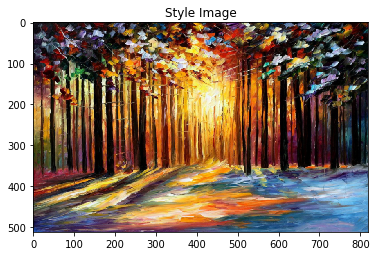

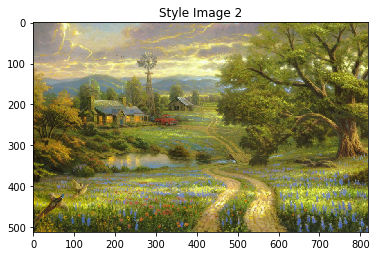

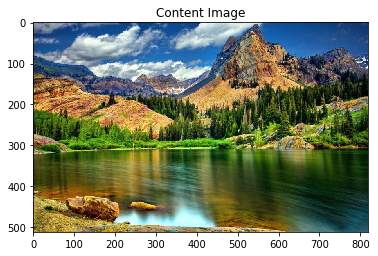

Building the style transfer model..
Optimizing..


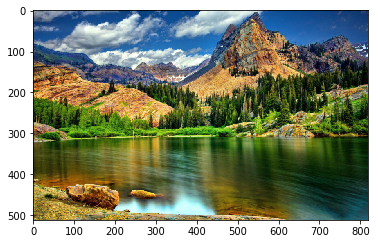

run [1]:
Style Loss : 112215.140625 Content Loss: 0.000000



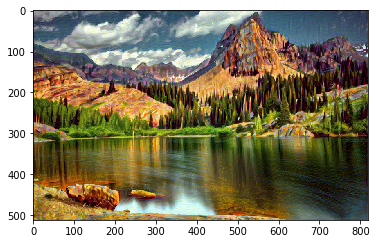

run [50]:
Style Loss : 50116.996094 Content Loss: 7.506611



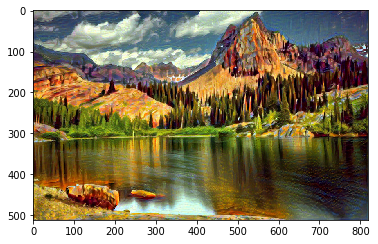

run [100]:
Style Loss : 49806.515625 Content Loss: 8.400901



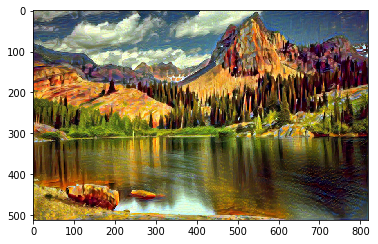

run [150]:
Style Loss : 49744.867188 Content Loss: 8.877007



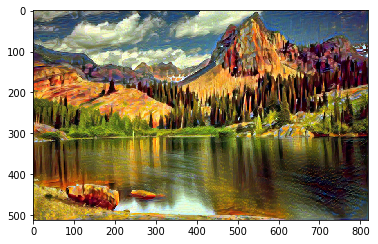

run [200]:
Style Loss : 49723.695312 Content Loss: 9.054911



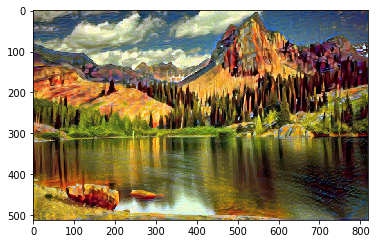

run [250]:
Style Loss : 49716.039062 Content Loss: 9.029548



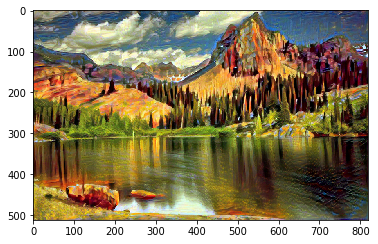

run [300]:
Style Loss : 49712.492188 Content Loss: 8.738630



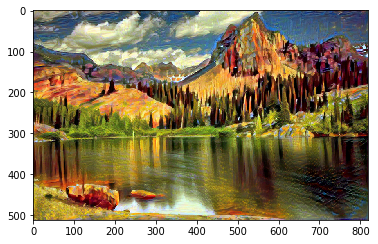

run [350]:
Style Loss : 49710.726562 Content Loss: 8.298722



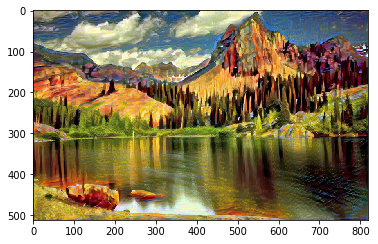

run [400]:
Style Loss : 49709.781250 Content Loss: 7.810248



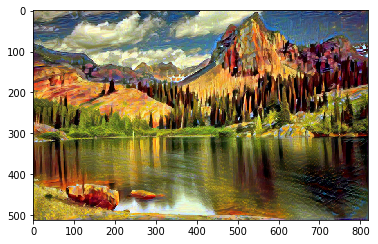

run [450]:
Style Loss : 49709.214844 Content Loss: 7.353850



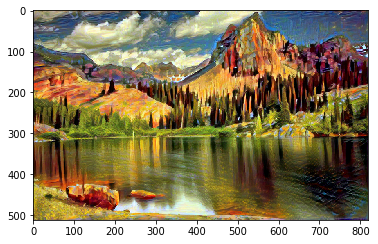

run [500]:
Style Loss : 49708.859375 Content Loss: 6.914619



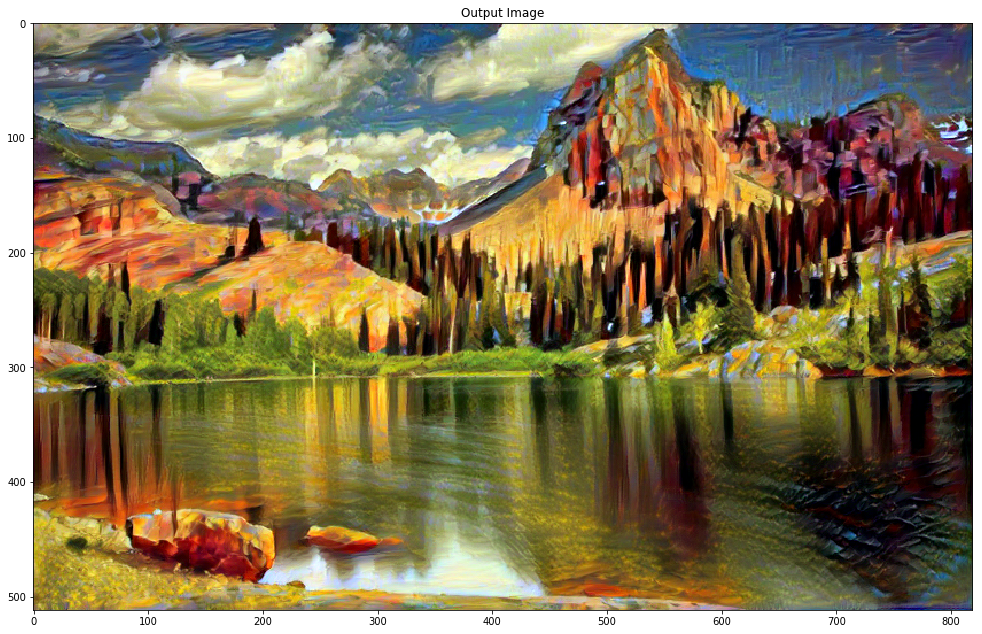

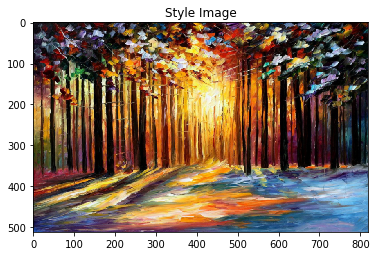

<Figure size 432x288 with 0 Axes>

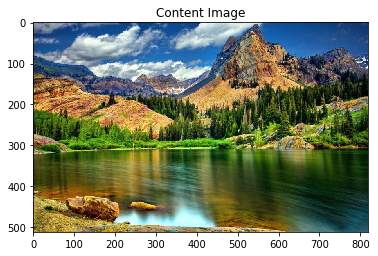

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from google.colab import files

from tensorboardX import SummaryWriter

import copy
import requests


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

#SummaryWriter encapsulates everything
writer = SummaryWriter('runs/exp-1')

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

  
unloader = transforms.ToPILImage()  # reconvert into PIL image

#https://i.imgur.com/fE2sSEd.jpg

style_img = image_loader("https://i.imgur.com/D9xaBtP.jpg")
style_img_2 = image_loader("https://i.imgur.com/fE2sSEd.jpghttps://i.imgur.com/fE2sSEd.jpg")
content_img = image_loader("https://i.imgur.com/2Saq7Nd.jpg")

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_2, title="Style Image 2")

plt.figure()
imshow(content_img, title='Content Image')


class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) / 2
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().requires_grad_(True).view(-1, 1, 1)
        self.std = std.clone().detach().requires_grad_(True).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']



def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            writer.add_histogram("weight", layer.weight, i)
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            # add style loss 2:
            target_feature = model(style_img_2).detach()
            style_loss_2 = StyleLoss(target_feature)
            model.add_module("style_loss_2_{}".format(i), style_loss_2)
            style_losses.append(style_loss_2)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=10000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    img = input_img.squeeze(0)
    writer.add_image("input_image", img, 0)
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            parameters = model(input_img)
            writer.add_histogram('param', parameters, run[0])
            style_score = 0
            style_score_blending = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss     

              
            style_score *= style_weight
            content_score *= content_weight
            
            writer.add_scalar('style_loss', style_score.item(), run[0])
            writer.add_scalar('content_loss', content_score.item(), run[0])
            
            loss = style_score + content_score
            writer.add_scalar('total_loss', loss, run[0])
            loss.backward(retain_graph=True)
            

            run[0] += 1
            
            if run[0] % 50 == 0 or run[0] == 1:
                imshow(input_img)
                img = input_img.squeeze(0)
                writer.add_image("input_image", img, run[0])
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    writer.add_image("input_image", img, run[0])

    return input_img


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)


plt.figure(figsize=(19.20,10.80))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
#imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')



